In [1]:
import numpy as np
from FlagRep import FlagRep
from matplotlib import pyplot as plt

import scipy.io as sio

from tqdm import tqdm

import pandas as pd

In [2]:
def relative_log_mse(D_rec, D_true):
    return 10*np.log10(np.linalg.norm(D_rec - D_true, 'fro')**2/(np.linalg.norm(D_true, 'fro')**2))

# Trying with HS data

In [3]:
fl_type = [8,9,10]
height, width = (50,50)
distributions = ['Normal', 'Exponential', 'Uniform']

In [4]:
results = pd.DataFrame(columns = ['Method', 'SNR (dB)', 'Added Noise', 'LRSE', 'DataSet', 'Distribution'])

for data_name in ['KSC', 'Indian Pines']:
    if data_name == 'Indian Pines':
        # Load the hyperspectral image and ground truth
        data = sio.loadmat('../data/indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected'] 
        labels = sio.loadmat('../data/indian_pines/Indian_pines_gt.mat')['indian_pines_gt']  # Shape: (145, 145)
    elif data_name == 'KSC':
        data = sio.loadmat('../data/KSC/KSC_corrected.mat')['KSC']
        labels = sio.loadmat('../data/KSC/KSC_gt.mat')['KSC_gt']

    image_height, image_width, n_bands = data.shape
    
    As = [np.arange(40), np.arange(100), np.arange(n_bands)]

    for noise_dist in distributions:

        for noise_scale in tqdm(np.arange(1,20)):
            noise_scale = .1*noise_scale
            
            for r_seed in range(20):
                np.random.seed(r_seed)
                # Assume `image` is a NumPy array with shape (height, width, channels)
                
                # Define the crop size
                crop_height = height
                crop_width = width

                # Randomly select the starting point for the crop
                x_start = np.random.randint(0, image_width - crop_width + 1)
                y_start = np.random.randint(0, image_height - crop_height + 1)

                # Crop the image
                cropped_image = data[y_start:y_start + crop_height, x_start:x_start + crop_width]

                n = width*height
                D_true = cropped_image.reshape((width*height, n_bands))

                D_true = D_true/D_true.max() #max normalization

                if noise_dist == 'Normal':
                    noise = np.random.normal(scale = noise_scale, size = (n,n_bands))
                elif noise_dist == 'Exponential':
                    noise = np.random.exponential(scale = noise_scale, size = (n,n_bands))
                elif noise_dist == 'Uniform':
                    noise = noise_scale*np.random.uniform(size = (n,n_bands))

                D_noisy = D_true + noise

                snr = 10*np.log10(np.linalg.trace(D_true@D_true.T)/np.linalg.trace(noise@noise.T))

                U, _, _ = np.linalg.svd(D_noisy)
                D_svd = U[:,:fl_type[-1]] @ U[:,:fl_type[-1]].T @ D_noisy
                svd_lrse = relative_log_mse(D_svd,D_true)
                row = pd.DataFrame(columns = results.columns, data = [['SVD', snr, noise_scale, svd_lrse, data_name, noise_dist]])
                results = pd.concat([results, row])

                my_fr = FlagRep(As, flag_type = fl_type)
                X,R = my_fr.fit_transform(D_noisy)
                D_flagrep = X @ R
                flagrep_lrse = relative_log_mse(D_flagrep,D_true)
                row = pd.DataFrame(columns = results.columns,  data = [['FlagRep', snr, noise_scale, flagrep_lrse,  data_name, noise_dist]])
                results = pd.concat([results, row])


  0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_198162/1407485004.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row])
100%|██████████| 19/19 [04:43<00:00, 14.93s/it]


<Figure size 200x500 with 0 Axes>

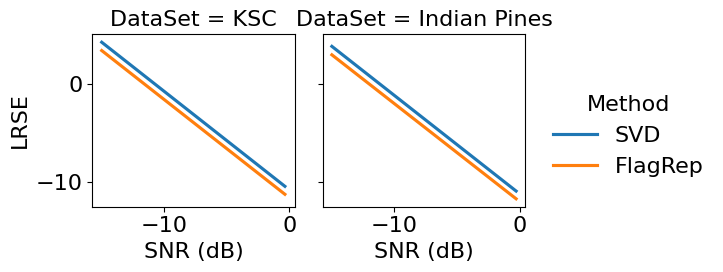

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
results = pd.read_csv('../results/HSI_denoising.csv')

normal_results = results[results['Distribution'] == 'Normal']
normal_results = normal_results[normal_results['SNR (dB)'] < 0]
normal_results = normal_results[normal_results['SNR (dB)'] >-15]

import seaborn as sns

plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (2,5))
g = sns.FacetGrid(
    normal_results,
    col="DataSet",
    hue="Method",
    margin_titles=True,
    despine=False
)

# Map the lineplot onto each subplot in the FacetGrid
g.map(sns.regplot, "SNR (dB)", "LRSE", scatter = False)


# Add legend
legend = g.add_legend()
# legend.set_bbox_to_anchor([0.2, 0.5]) 

# Adjust layout to fit labels and titles
# g.fig.tight_layout()

# Display the plot
# plt.show()

# plt.tight_layout()
plt.savefig('../results/RS_Reconstruction.pdf', bbox_inches = 'tight')

In [19]:
results.to_csv('../results/HSI_denoising.csv')